In [217]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import warnings

import pickle

from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

# Experiment Parameters

In [249]:
width = 4
n = 50000
acc_thresh = 0.98
epochs = 5

train_new = True

# Data Generation
## Function

In [250]:
def generate_XOR(n):
    '''
    means = np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]])
    X = np.concatenate([np.random.uniform(low = -1, high = 1, size = (n, 1)) for _ in range(2)], axis = 1)

    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

    return X, y
    '''
    means = np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]])
    X = np.concatenate([np.random.multivariate_normal(mean, 0.1 * np.eye(len(mean)),
                                                 size=int(n / 4)) for mean in means])

    y = np.concatenate([np.ones(int(n / 4)) * int(idx < 2) for idx in range(len(means))])

    random_indices_order = list(range(len(X)))
    np.random.shuffle(random_indices_order)
    return X[random_indices_order], np.array(y[random_indices_order]).astype('int')

## Training Data

In [251]:
X, y = generate_XOR(n = n)

## Grid Generation

In [252]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min) / 100),
                      np.arange(y_min, y_max, (y_max - y_min) / 100))

# Construct & Train Network

In [253]:
def get_network():
    network = keras.Sequential()
    network.add(keras.layers.Dense(width, input_shape = np.shape(X)[1:], activation = 'relu', use_bias=True, kernel_initializer = 'he_normal'))
    network.add(keras.layers.Dense(1, activation = 'sigmoid', use_bias=True, kernel_initializer = 'he_normal'))
    network.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(1e-2, momentum = 0.9), metrics = ['acc'])
    return network

In [254]:
if train_new:
    acc = 0
    while acc < acc_thresh:
      network = get_network()
      network.fit(
          X, 
          y, 
          epochs = epochs, 
          verbose = True,
          batch_size = 256
      )

      acc = network.evaluate(X, y, verbose = False)[1]
      if acc >= acc_thresh:
        print("Done training. Acc = {:0.2f} > Acc Thresh = {:0.2f}.".format(acc, acc_thresh))
      else:
        print("Training New Network since Acc = {:0.2f} < Acc Thresh = {:0.2f}...".format(acc, acc_thresh))
      network.save_weights("best_weights.h5")
else:
    network = get_network()
    network.load_weights("best_weights.h5")

Epoch 1/5
50000/50000 [==============================] - 0s 10us/step - loss: 0.5273 - acc: 0.6867
Epoch 2/5
50000/50000 [==============================] - 0s 7us/step - loss: 0.2085 - acc: 0.9721
Epoch 3/5
50000/50000 [==============================] - 0s 7us/step - loss: 0.0952 - acc: 0.9947
Epoch 4/5
50000/50000 [==============================] - 0s 7us/step - loss: 0.0605 - acc: 0.9960
Epoch 5/5
50000/50000 [==============================] - 0s 7us/step - loss: 0.0450 - acc: 0.9965
Done training. Acc = 1.00 > Acc Thresh = 0.98.


## Polytope Pyramid

In [255]:
input_weights, ultimate_weights = [network.layers[i].get_weights()[0] for i in {0, 1}]
input_bias, ultimate_bias = [network.layers[i].get_weights()[1] for i in {0, 1}]

second_layer_preactivations = np.matmul(np.c_[xx.ravel(), yy.ravel()], input_weights) + input_bias 
second_layer_binary_activations = (second_layer_preactivations > 0).astype('int')
second_layer_activations = second_layer_preactivations * second_layer_binary_activations

ultimate_preactivations = np.matmul(second_layer_activations, ultimate_weights) + ultimate_bias
ultimate_binary_activations = (ultimate_preactivations > 0).astype('int')
ultimate_activations = ultimate_preactivations * ultimate_binary_activations

In [256]:
signed_second_layer_activations = (second_layer_preactivations > 0).astype('int')
signed_ultimate_activations = (ultimate_preactivations > 0).astype('int')

polytope_memberships = np.concatenate([signed_second_layer_activations, signed_ultimate_activations], axis = 1)
unique_polytope_ids, polytope_ids = np.unique(np.matmul(polytope_memberships, 2 ** np.arange(0, np.shape(polytope_memberships)[1])), return_inverse = True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: No contour levels were found within the data range.


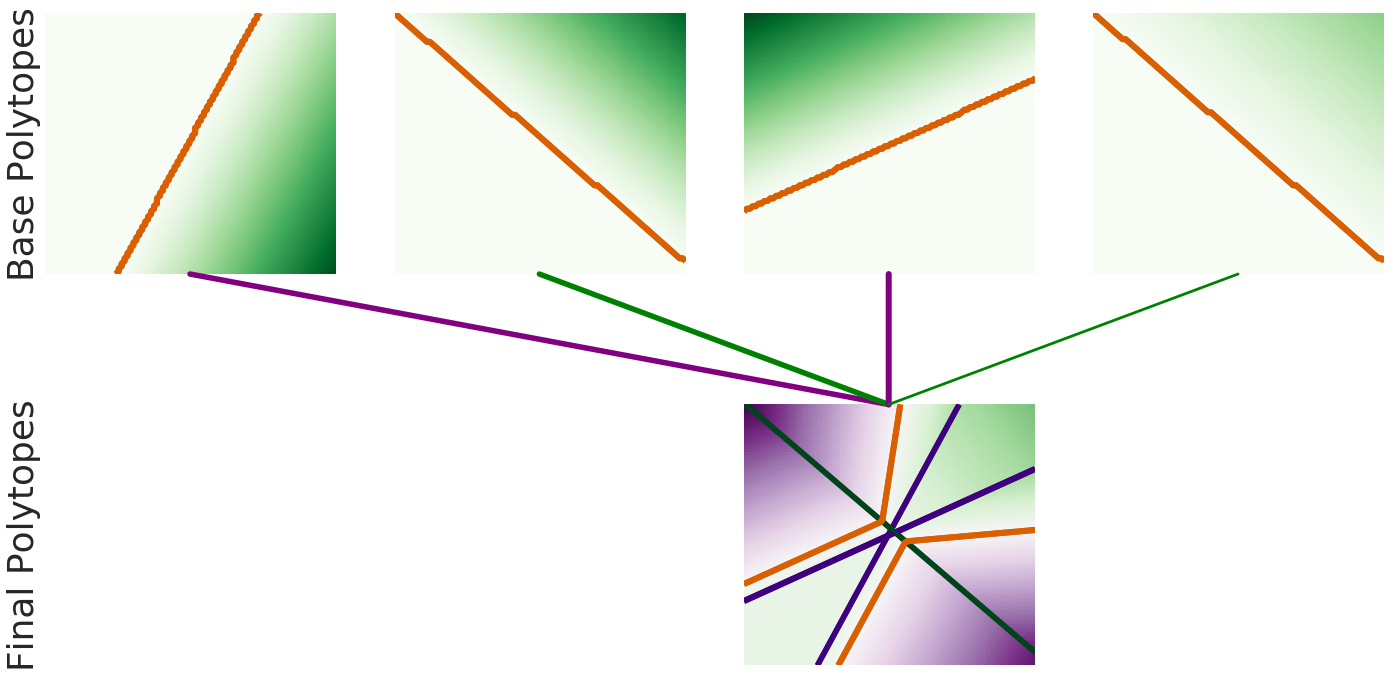

In [257]:
figs, axs = plt.subplots(2, width, figsize = (6 * width, 6 * 2))
plt.subplots_adjust(hspace=0.5)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    if int(i // width) == 0:
        ax.set_ylabel('Base Polytopes', fontsize = 36)
    elif int(i // width) == 1:
        ax.set_ylabel('Final Polytopes', fontsize = 36)
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
        
for second_node in range(width):
    for multiplier in [-1, 1]:
      axs[0][second_node].contour(xx, 
                                yy, 
                                second_layer_activations[:, second_node].reshape(xx.shape) + multiplier * 1e-6, 
                                levels=[0], 
                                colors="#d95f02",
                                vmin = -1, 
                                vmax = 0,
                                linewidths = 6)
    axs[0][second_node].pcolormesh(xx, 
                          yy, 
                          second_layer_activations[:, second_node].reshape(xx.shape), 
                          cmap="Greens", 
                          vmin = 0, 
                          vmax = np.max(second_layer_activations)
                          )

for second_node in range(width):
  second_w_sign = np.sign(ultimate_weights[second_node])
  second_node_contributes = np.abs(ultimate_weights[second_node]) > 1e-6

  if second_node_contributes:
    con = ConnectionPatch(axesA=axs[0][second_node], 
                        axesB=axs[1][int(width / 2)], 
                        xyA = [0, np.min(yy)],
                        xyB = [0, np.max(yy)],
                        coordsA="data", 
                        coordsB="data", 
                        color="green" if ultimate_weights[second_node] > 0 else "purple", 
                        lw=6 * np.abs(ultimate_weights[second_node]) / np.max(np.abs(ultimate_weights)))
    axs[1][int(width / 2)].add_artist(con)

for second_node in range(width):
    for multiplier in [-1, 1]:
      axs[1][int(width / 2)].contour(xx, 
                                       yy, 
                                       second_layer_preactivations[:, second_node].reshape(xx.shape) + multiplier * 1e-6, 
                                       levels=[0], 
                                       cmap="Greens" if ultimate_weights[second_node] > 0 else "Purples",
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6 * np.abs(ultimate_weights[second_node]) / np.max(np.abs(ultimate_weights))
                                    )

axs[1][int(width / 2)].pcolormesh(xx, 
                               yy, 
                               ultimate_preactivations.reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = -np.max(np.abs(ultimate_preactivations)), 
                               vmax = np.max(np.abs(ultimate_preactivations)))

for multiplier in [-1, 1]:
  axs[1][int(width / 2)].contour(xx, 
                               yy, 
                               ultimate_preactivations.reshape(xx.shape) + multiplier * 1e-6, 
                               colors="#d95f02", 
                               vmin = -1, 
                               vmax = 0,
                               levels=[0],
                               linewidths=6,
                               zorder = 1e16) 

In [258]:
def pdf(x):
    mu01, mu02, mu11, mu12 = [[-1, -1], [1, 1], [-1, 1], [1, -1]]
    cov = 0.25 * np.eye(2)
    inv_cov = np.linalg.inv(cov) 

    p0 = (
        np.exp(-(x - mu01)@inv_cov@(x-mu01).T) 
        + np.exp(-(x - mu02)@inv_cov@(x-mu02).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    p1 = (
        np.exp(-(x - mu11)@inv_cov@(x-mu11).T) 
        + np.exp(-(x - mu12)@inv_cov@(x-mu12).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    return p0/(p0+p1)

true_posterior = [pdf(x) for x in tqdm(np.c_[xx.ravel(), yy.ravel()])]


100%|██████████| 10100/10100 [00:01<00:00, 10060.40it/s]


In [259]:
if train_new:
    acc = 0
    while acc < acc_thresh:
      rfc = RandomForestClassifier(n_estimators = 2, 
                                   max_depth = width)

      rfc.fit(X, y)
      y_hat = rfc.predict(X)
      acc = np.mean(y_hat == y)
      if acc >= acc_thresh:
        print("Done training. Acc = {:0.2f} > Acc Thresh = {:0.2f}.".format(acc, acc_thresh))
      else:
        print("Training New Forest since Acc = {:0.2f} < Acc Thresh = {:0.2f}...".format(acc, acc_thresh))
    pickle.dump(rfc, open('best_forest.pkl', 'wb'))
else:
    rfc = pickle.load(open('best_forest.pkl', 'rb'))

Training New Forest since Acc = 0.79 < Acc Thresh = 0.98...
Training New Forest since Acc = 0.85 < Acc Thresh = 0.98...
Done training. Acc = 1.00 > Acc Thresh = 0.98.


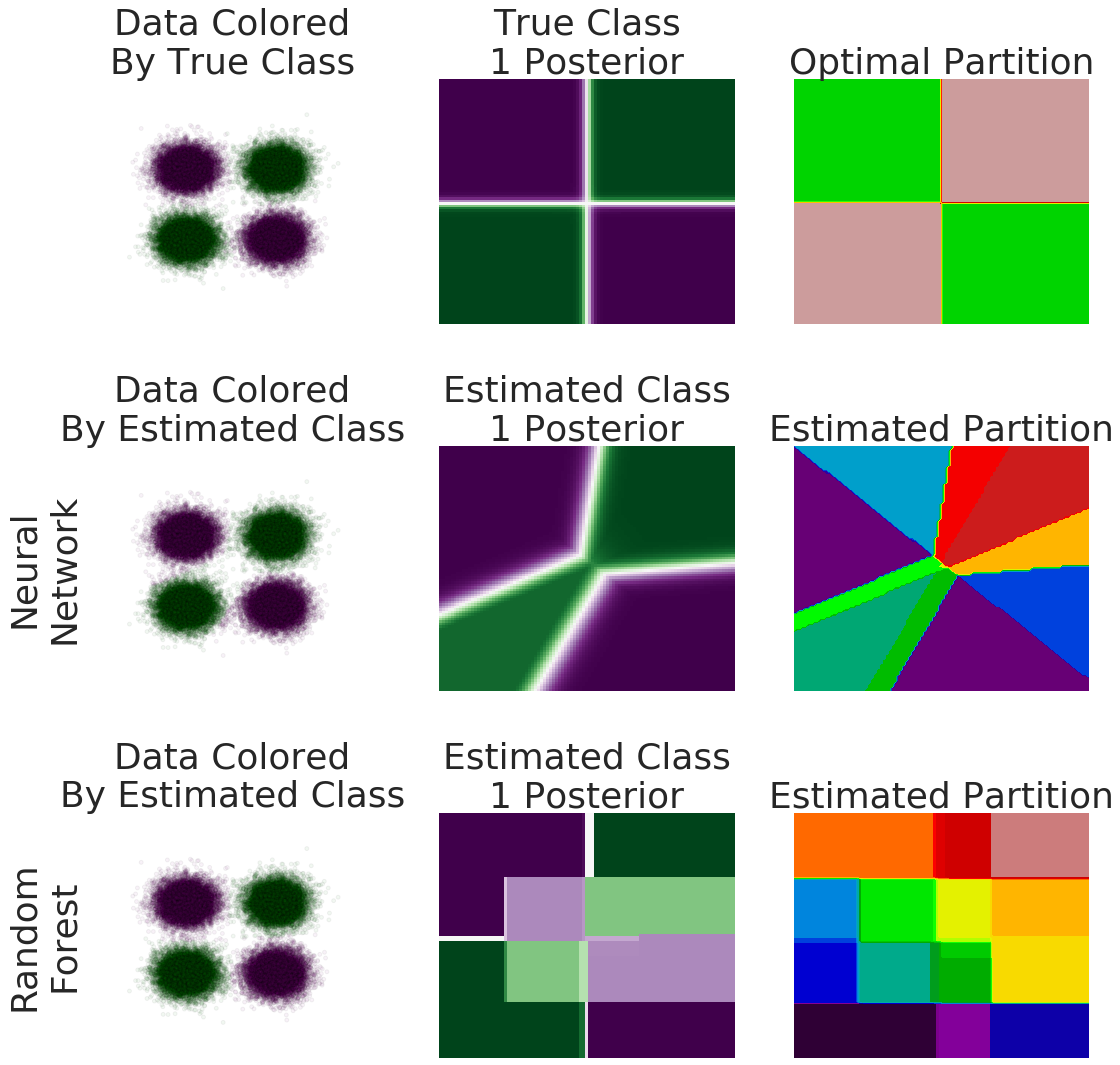

In [260]:
figs, axs = plt.subplots(3, 3, figsize = (6 * 3, 6 * 3))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 2.5)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
        
for i in range(3):
    axs[i][0].set_ylim((np.min(yy), np.max(yy)))
    axs[i][0].set_xlim((np.min(xx), np.max(xx)))
        
# Plot the training points
axs[0][0].scatter(X[:, 0], X[:, 1], c=['green' if y[i] == 1 else 'purple' for i in range(len(y))],
          s=15, edgecolor = 'black', alpha = .05)
axs[0][0].set_title("Data Colored\nBy True Class", fontsize = 36)

axs[0][1].set_title("True Class\n1 Posterior", fontsize = 36)
axs[0][1].pcolormesh(xx, 
                               yy, 
                               np.array(true_posterior).reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

axs[0][2].set_title("Optimal Partition", fontsize = 36)
c = np.array([int(np.sign(np.prod(ra)) == 1) for ra in np.c_[xx.ravel(), yy.ravel()]])
#c = np.array([np.sum((ra > 0).astype('int') * 2 ** np.arange(0, len(ra))) for ra in np.c_[xx.ravel(), yy.ravel()]])
axs[0][2].contourf(xx, yy, c.reshape(xx.shape), cmap = "nipy_spectral", vmin = -1, vmax = 1)

y_hat = (network.predict_proba(X) > 0.5).astype('int')
axs[1][0].scatter(X[:, 0], X[:, 1], c=['green' if y_hat[i] == 1 else 'purple' for i in range(len(y))],
          s=15, edgecolor = 'black', alpha = .05)
axs[1][0].set_title("Data Colored\nBy Estimated Class", fontsize = 36)
axs[1][0].set_ylabel("Neural\nNetwork", fontsize = 36)

axs[1][1].set_title("Estimated Class\n1 Posterior", fontsize = 36)

estimated_class_1_posterior = 1 / (1 + np.exp(-ultimate_preactivations))
axs[1][1].pcolormesh(xx, 
                               yy, 
                               estimated_class_1_posterior.reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

axs[1][2].contourf(xx, yy, polytope_ids.reshape(xx.shape), cmap = "nipy_spectral", levels = len(np.unique(polytope_ids)))
axs[1][2].set_title("Estimated Partition", fontsize = 36)

y_hat = rfc.predict(X)
axs[2][0].scatter(X[:, 0], X[:, 1], c=['green' if y_hat[i] == 1 else 'purple' for i in range(len(y))],
          s=15, edgecolor = 'black', alpha = .05)
axs[2][0].set_title("Data Colored\nBy Estimated Class", fontsize = 36)
axs[2][0].set_ylabel("Random\nForest", fontsize = 36)

axs[2][1].set_title("Estimated Class\n1 Posterior", fontsize = 36)

estimated_class_1_posterior = rfc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
axs[2][1].pcolormesh(xx, 
                               yy, 
                               estimated_class_1_posterior.reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

predicted_leaf_ids_across_trees = np.array([keras.utils.to_categorical(np.unique(tree.apply(np.c_[xx.ravel(), yy.ravel()]), return_inverse = True)[1], num_classes = 2 ** (width + 1)) for tree_idx, tree in enumerate(rfc.estimators_)])
length = np.shape(predicted_leaf_ids_across_trees)[-1]
partition_ids = np.matmul(predicted_leaf_ids_across_trees[0], np.expand_dims(np.logspace(0, length, num = length, base = 2), axis = 1)) + np.matmul(predicted_leaf_ids_across_trees[1], np.expand_dims(np.logspace(length, 2*length, num = length, base = 2), axis = 1))
_, partition_ids = np.unique(partition_ids, return_inverse = True)

axs[2][2].contourf(xx, yy, partition_ids.reshape(xx.shape), cmap = "nipy_spectral", levels = len(np.unique(partition_ids)))
axs[2][2].set_title("Estimated Partition", fontsize = 36)

plt.show()

## Keurnal Networks

In [261]:
X, y = generate_XOR(n = n)

In [270]:
def get_KDEs(polytope_ids):
    #an array of all of the X-values of the class-wise means in each leaf
    polytope_means_X = []

    #an array of all of the y-values (i.e. class values) of the class-wise means in each leaf
    polytope_means_y = []

    #an array of all of the number of points that comprise the means in each leaf
    polytope_means_weight = []

    #an array of all of the average variances of the points in each leaf corresponding to 
    #a single class from the class-wise mean in that leaf
    polytope_means_var = []

    polytope_KDEs = []

    for polytope_value in np.unique(polytope_ids):
        for y_val in np.unique(y):
            idxs_in_polytope_of_class = np.where((y == y_val) & (polytope_ids == polytope_value))[0]
            if len(idxs_in_polytope_of_class) > 1:
                mean_X_in_polytope_of_class = np.mean(X[idxs_in_polytope_of_class], axis = 0)
                polytope_means_X.append(mean_X_in_polytope_of_class)
                #we already know the y value, so just append it 
                polytope_means_y.append(y_val)
                #compute the number of points in that leaf corresponding to that y value
                #and append to the aggregate array
                polytope_means_weight.append(len(idxs_in_polytope_of_class))
                #compute the distances of all the points in that leaf corresponding to that y value
                #from the mean X-value of the points in that leaf corresponding to that y value
                dists_in_polytope = np.sqrt(np.sum((X[idxs_in_polytope_of_class] - mean_X_in_polytope_of_class)**2, axis = 1))
                #compute the variance as the average distance of the class-wise points in that leaf 
                #and append to the aggregate array
                polytope_means_var.append(np.mean(dists_in_polytope))



    #convert to numpy array so we can easily refer to multiple sets of points as ra[idxs]
    polytope_means_y, polytope_means_X, polytope_means_weight, polytope_means_var = np.array(polytope_means_y), np.array(polytope_means_X), np.array(polytope_means_weight), np.array(polytope_means_var)

    #an array of all of the KDEs. Each KDE will be respondsible for computing the probability 
    #that a given set of inference points belongs to that class. Thus, we have separate KDEs 
    #for each class. The KDE at index i is the KDE that is responsible for computations on 
    #y_value = i
    KDEs = []
    #loop over the y values in the leaf means 
    for y_val in np.unique(polytope_means_y):
        #gather all of the leaf means corresponding to the given y value
        polytope_means_X_of_y_val = polytope_means_X[np.where(polytope_means_y == y_val)[0]]
        #father all of the weights corresponding to the given y value
        polytope_means_weight_of_y_val = polytope_means_weight[np.where(polytope_means_y == y_val)[0]]
        #compute the bandwidth as the average variance across the class-wise leaf means, weighted
        #by the number of points
        polytope_means_var_of_y_val = polytope_means_var[np.where(polytope_means_y == y_val)[0]]
        bandwidth=np.average(polytope_means_var_of_y_val, weights = polytope_means_weight_of_y_val)
        #train an sklearn KDE with a gaussian kernel with the bandwidth calculated above
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        #fit the KDE on the leaf means corresponding to the given y value, weighted by
        #the weights corresponding to the given y value
        kde.fit(X = polytope_means_X_of_y_val, sample_weight = polytope_means_weight_of_y_val)

        #append the KDE to the aggregate array
        KDEs.append(kde)
    return KDEs, polytope_means_X, polytope_means_y, polytope_means_weight


second_layer_preactivations = np.matmul(X, input_weights) + input_bias 
second_layer_binary_activations = (second_layer_preactivations > 0).astype('int')
second_layer_activations = second_layer_preactivations * second_layer_binary_activations

ultimate_preactivations = np.matmul(second_layer_activations, ultimate_weights) + ultimate_bias
ultimate_binary_activations = (ultimate_preactivations > 0).astype('int')
ultimate_activations = ultimate_preactivations * ultimate_binary_activations

signed_second_layer_activations = (second_layer_activations > 0).astype('int')
signed_ultimate_activations = (ultimate_activations > 0).astype('int')

polytope_memberships = np.concatenate([signed_second_layer_activations, signed_ultimate_activations], axis = 1)
_, neural_polytope_ids = np.unique(np.matmul(polytope_memberships, 2 ** np.arange(0, np.shape(polytope_memberships)[1])), return_inverse = True)

neural_KDEs, neural_polytope_means_X, neural_polytope_means_y, neural_polytope_means_weight = get_KDEs(neural_polytope_ids)

predicted_leaf_ids_across_trees = np.array([keras.utils.to_categorical(np.unique(tree.apply(X), return_inverse = True)[1], num_classes = 2 ** (width + 1)) for tree_idx, tree in enumerate(rfc.estimators_)])
length = np.shape(predicted_leaf_ids_across_trees)[-1]
forest_partition_ids = np.matmul(predicted_leaf_ids_across_trees[0], np.expand_dims(np.logspace(0, length, num = length, base = 2), axis = 1)) + np.matmul(predicted_leaf_ids_across_trees[1], np.expand_dims(np.logspace(length, 2*length, num = length, base = 2), axis = 1))
_, forest_partition_ids = np.unique(forest_partition_ids, return_inverse = True)

forest_KDEs, forest_polytope_means_X, forest_polytope_means_y, forest_polytope_means_weight = get_KDEs(forest_partition_ids)

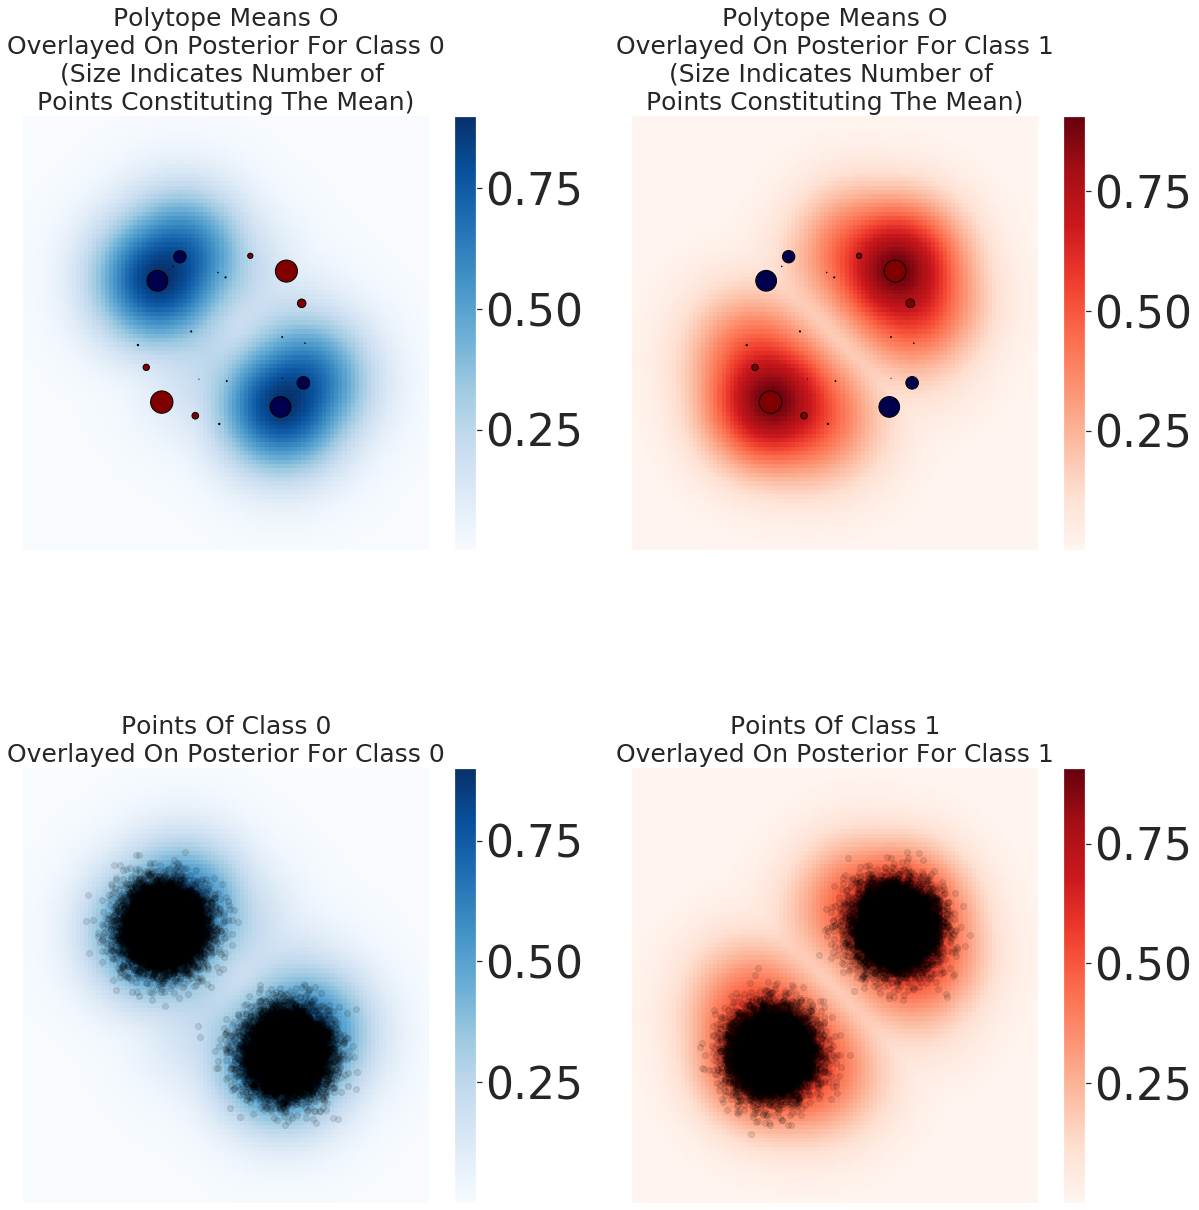

In [271]:
figs, axs = plt.subplots(2, 2, figsize = (20, 20))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 4)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
    
#instantiate the posterior predictions
y_proba_neural_KDE_grid = np.zeros((len(np.c_[xx.ravel(), yy.ravel()]), len(neural_KDEs)))

#loops over the KDEs (and thus, implicitly, the y-values)
for y_val in range(len(neural_KDEs)):
    #compute the (unnormalized) posterior for the KDE corresponding
    #to y_val. NOTE: we perform np.exp since the score_samples 
    #function returns the log of the probability of belonging to that 
    #class, so we must invert the log through an exponential
    y_proba_neural_KDE_grid[:, y_val] = np.clip(np.exp(neural_KDEs[y_val].score_samples(np.c_[xx.ravel(), yy.ravel()])), a_max = 1, a_min = 0)

    for i in range(2):
        figs.colorbar(axs[i][y_val].pcolormesh(xx, 
               yy,          
               y_proba_neural_KDE_grid[:, y_val].reshape(xx.shape) ** .2,
               cmap = "Reds" if y_val == 1 else "Blues"),
                 ax = axs[i][y_val])
    
    axs[0][y_val].scatter(neural_polytope_means_X[:, 0], neural_polytope_means_X[:, 1], c = 2 * neural_polytope_means_y - 1, s = 500 * np.array(neural_polytope_means_weight) / np.max(neural_polytope_means_weight), edgecolor = 'black', cmap = "seismic")
    axs[0][y_val].set_title("Polytope Means O\nOverlayed On Posterior For Class {}\n(Size Indicates Number of \nPoints Constituting The Mean)".format(y_val), fontsize = 25)
    
    
y_proba_neural_KDE = np.zeros((len(X), len(neural_KDEs)))

#loops over the KDEs (and thus, implicitly, the y-values)
for y_val in range(len(neural_KDEs)):
    #compute the (unnormalized) posterior for the KDE corresponding
    #to y_val. NOTE: we perform np.exp since the score_samples 
    #function returns the log of the probability of belonging to that 
    #class, so we must invert the log through an exponential
    y_proba_neural_KDE[:, y_val] = np.clip(np.exp(neural_KDEs[y_val].score_samples(X) / 10), a_max = 1, a_min = 0)
    
for y_val in range(2):
    idxs_of_class = np.where(y == y_val)
    axs[1][y_val].set_title("Points Of Class {}\nOverlayed On Posterior For Class {}".format(y_val, y_val), fontsize = 25)
    axs[1][y_val].scatter(X[idxs_of_class, 0], X[idxs_of_class, 1], c = 'black', alpha = .1)

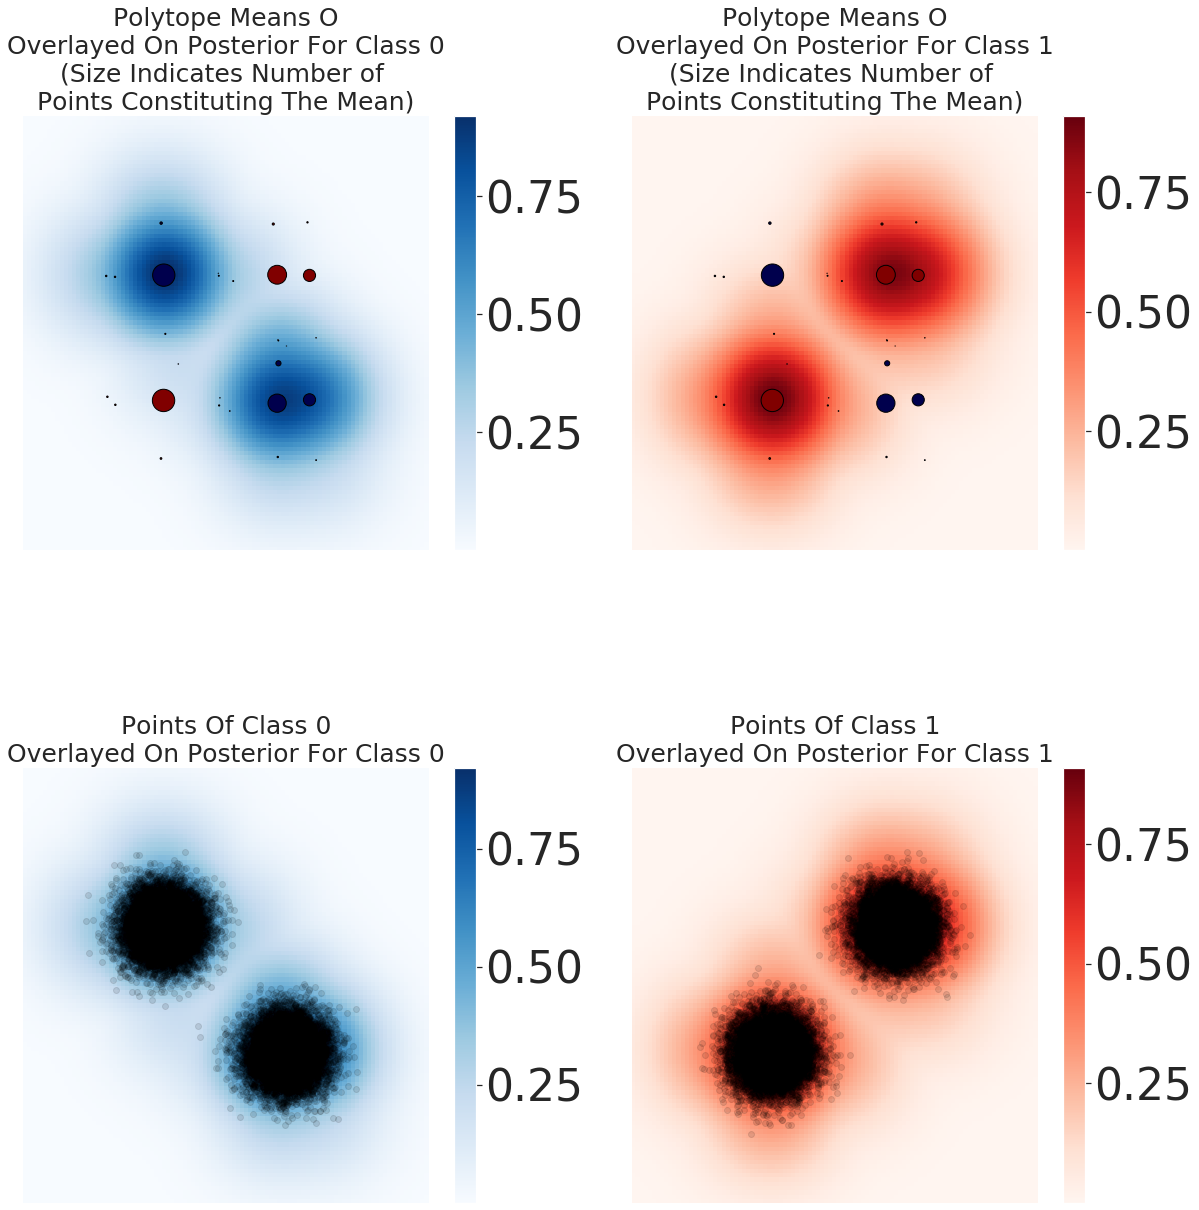

In [272]:
figs, axs = plt.subplots(2, 2, figsize = (20, 20))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 4)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
    
#instantiate the posterior predictions
y_proba_forest_KDE_grid = np.zeros((len(np.c_[xx.ravel(), yy.ravel()]), len(forest_KDEs)))

#loops over the KDEs (and thus, implicitly, the y-values)
for y_val in range(len(forest_KDEs)):
    #compute the (unnormalized) posterior for the KDE corresponding
    #to y_val. NOTE: we perform np.exp since the score_samples 
    #function returns the log of the probability of belonging to that 
    #class, so we must invert the log through an exponential
    y_proba_forest_KDE_grid[:, y_val] = np.clip(np.exp(forest_KDEs[y_val].score_samples(np.c_[xx.ravel(), yy.ravel()])), a_max = 1, a_min = 0)

    for i in range(2):
        figs.colorbar(axs[i][y_val].pcolormesh(xx, 
               yy,          
               y_proba_forest_KDE_grid[:, y_val].reshape(xx.shape) ** .2,
               cmap = "Reds" if y_val == 1 else "Blues"),
                 ax = axs[i][y_val])
    
    axs[0][y_val].scatter(forest_polytope_means_X[:, 0], forest_polytope_means_X[:, 1], c = 2 * forest_polytope_means_y - 1, s = 500 * np.array(forest_polytope_means_weight) / np.max(forest_polytope_means_weight), edgecolor = 'black', cmap = "seismic")
    axs[0][y_val].set_title("Polytope Means O\nOverlayed On Posterior For Class {}\n(Size Indicates Number of \nPoints Constituting The Mean)".format(y_val), fontsize = 25)
    
    
y_proba_forest_KDE = np.zeros((len(X), len(forest_KDEs)))

#loops over the KDEs (and thus, implicitly, the y-values)
for y_val in range(len(forest_KDEs)):
    #compute the (unnormalized) posterior for the KDE corresponding
    #to y_val. NOTE: we perform np.exp since the score_samples 
    #function returns the log of the probability of belonging to that 
    #class, so we must invert the log through an exponential
    y_proba_forest_KDE[:, y_val] = np.clip(np.exp(forest_KDEs[y_val].score_samples(X) / 10), a_max = 1, a_min = 0)
    
for y_val in range(2):
    idxs_of_class = np.where(y == y_val)
    axs[1][y_val].set_title("Points Of Class {}\nOverlayed On Posterior For Class {}".format(y_val, y_val), fontsize = 25)
    axs[1][y_val].scatter(X[idxs_of_class, 0], X[idxs_of_class, 1], c = 'black', alpha = .1)

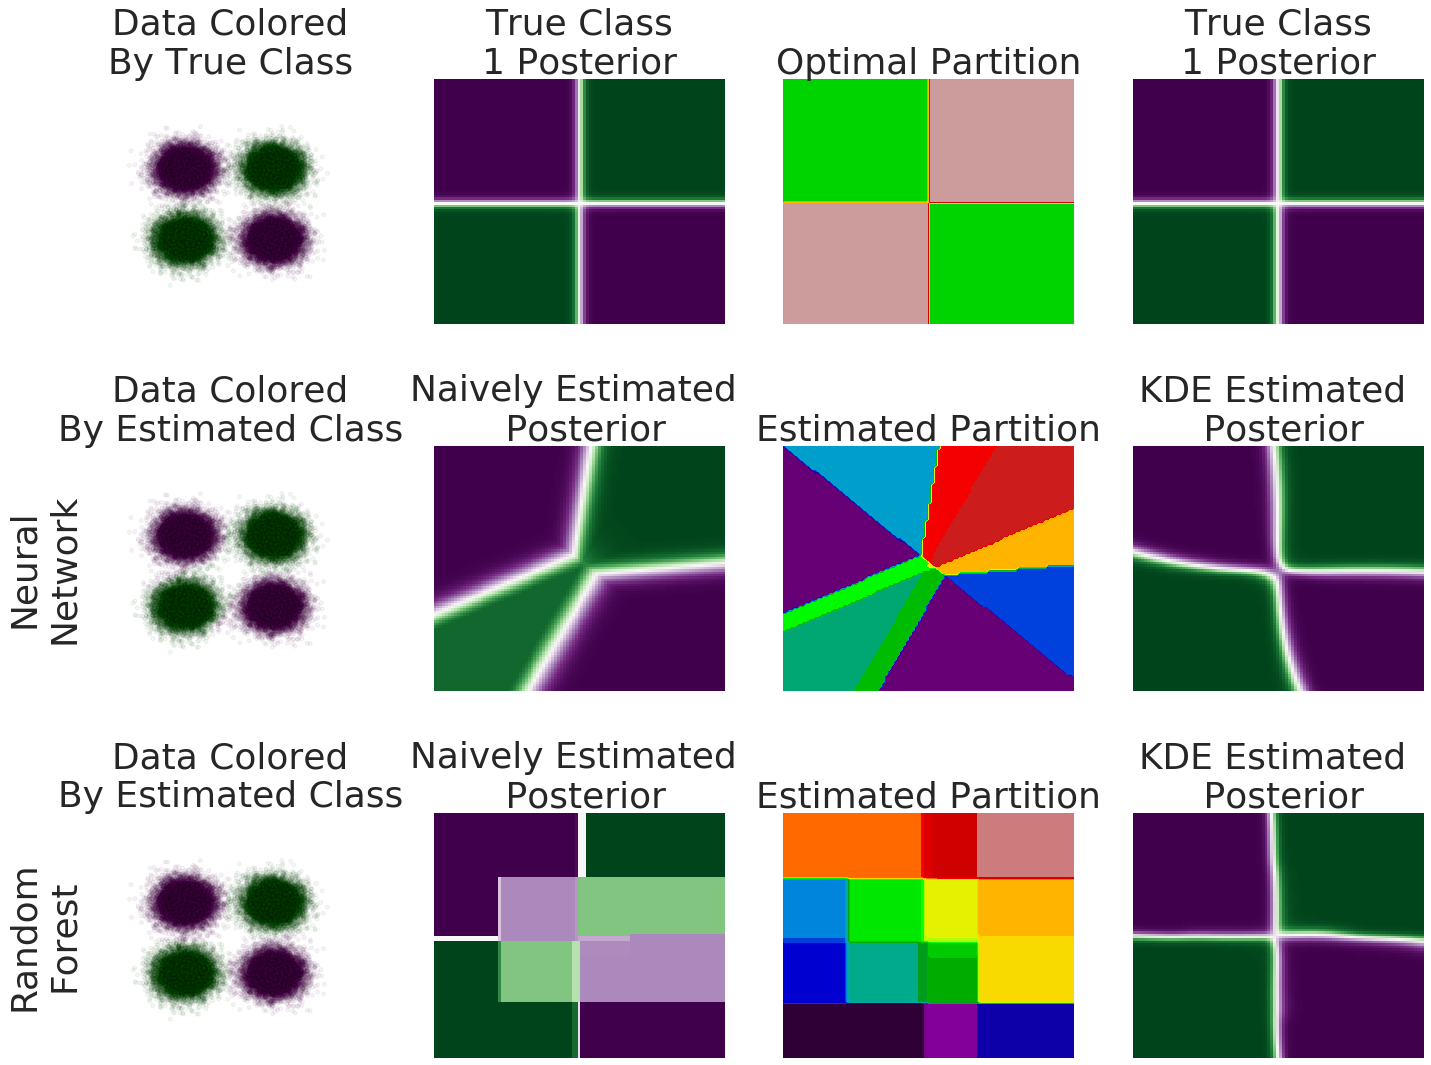

In [274]:
figs, axs = plt.subplots(3, 4, figsize = (6 * 4, 6 * 3))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 2.5)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
        
for i in range(3):
    axs[i][0].set_ylim((np.min(yy), np.max(yy)))
    axs[i][0].set_xlim((np.min(xx), np.max(xx)))
        
# Plot the training points
axs[0][0].scatter(X[:, 0], X[:, 1], c=['green' if y[i] == 1 else 'purple' for i in range(len(y))],
          s=15, edgecolor = 'black', alpha = .05)
axs[0][0].set_title("Data Colored\nBy True Class", fontsize = 36)

axs[0][1].set_title("True Class\n1 Posterior", fontsize = 36)
axs[0][1].pcolormesh(xx, 
                               yy, 
                               np.array(true_posterior).reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

axs[0][2].set_title("Optimal Partition", fontsize = 36)
c = np.array([int(np.sign(np.prod(ra)) == 1) for ra in np.c_[xx.ravel(), yy.ravel()]])
#c = np.array([np.sum((ra > 0).astype('int') * 2 ** np.arange(0, len(ra))) for ra in np.c_[xx.ravel(), yy.ravel()]])
axs[0][2].contourf(xx, yy, c.reshape(xx.shape), cmap = "nipy_spectral", vmin = -1, vmax = 1)

axs[0][3].set_title("True Class\n1 Posterior", fontsize = 36)
axs[0][3].pcolormesh(xx, 
                               yy, 
                               np.array(true_posterior).reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

y_hat = (network.predict_proba(X) > 0.5).astype('int')
axs[1][0].scatter(X[:, 0], X[:, 1], c=['green' if y_hat[i] == 1 else 'purple' for i in range(len(y))],
          s=15, edgecolor = 'black', alpha = .05)
axs[1][0].set_title("Data Colored\nBy Estimated Class", fontsize = 36)
axs[1][0].set_ylabel("Neural\nNetwork", fontsize = 36)

axs[1][1].set_title("Naively Estimated \n Posterior", fontsize = 36)

estimated_class_1_posterior = network.predict(np.c_[xx.ravel(), yy.ravel()])
axs[1][1].pcolormesh(xx, 
                               yy, 
                               estimated_class_1_posterior.reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

axs[1][2].contourf(xx, yy, polytope_ids.reshape(xx.shape), cmap = "nipy_spectral", levels = len(np.unique(polytope_ids)))
axs[1][2].set_title("Estimated Partition", fontsize = 36)
axs[1][3].set_title("KDE Estimated \n Posterior", fontsize = 36)
axs[1][3].pcolormesh(xx, 
                               yy, 
                               (y_proba_neural_KDE_grid[:, 1] / np.sum(y_proba_neural_KDE_grid, axis = 1)).reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

y_hat = rfc.predict(X)
axs[2][0].scatter(X[:, 0], X[:, 1], c=['green' if y_hat[i] == 1 else 'purple' for i in range(len(y))],
          s=15, edgecolor = 'black', alpha = .05)
axs[2][0].set_title("Data Colored\nBy Estimated Class", fontsize = 36)
axs[2][0].set_ylabel("Random\nForest", fontsize = 36)

axs[2][1].set_title("Naively Estimated \n Posterior", fontsize = 36)

estimated_class_1_posterior = rfc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
axs[2][1].pcolormesh(xx, 
                               yy, 
                               estimated_class_1_posterior.reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

predicted_leaf_ids_across_trees = np.array([keras.utils.to_categorical(np.unique(tree.apply(np.c_[xx.ravel(), yy.ravel()]), return_inverse = True)[1], num_classes = 2 ** (width + 1)) for tree_idx, tree in enumerate(rfc.estimators_)])
length = np.shape(predicted_leaf_ids_across_trees)[-1]
partition_ids = np.matmul(predicted_leaf_ids_across_trees[0], np.expand_dims(np.logspace(0, length, num = length, base = 2), axis = 1)) + np.matmul(predicted_leaf_ids_across_trees[1], np.expand_dims(np.logspace(length, 2*length, num = length, base = 2), axis = 1))
_, partition_ids = np.unique(partition_ids, return_inverse = True)

axs[2][2].contourf(xx, yy, partition_ids.reshape(xx.shape), cmap = "nipy_spectral", levels = len(np.unique(partition_ids)))
axs[2][2].set_title("Estimated Partition", fontsize = 36)

axs[2][3].set_title("KDE Estimated \n Posterior", fontsize = 36)
axs[2][3].pcolormesh(xx, 
                               yy, 
                               (y_proba_forest_KDE_grid[:, 1] / np.sum(y_proba_forest_KDE_grid, axis = 1)).reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

plt.show()